In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython import display

import os


rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path, encoding='latin-1') as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

# display.display(pos_review.head(), neg_review.head())

In [3]:
all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


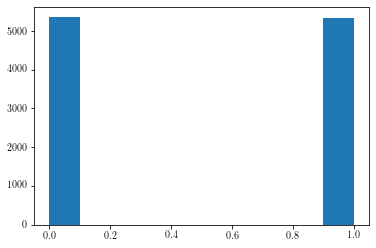

In [4]:
plt.hist(all_reviews.sentiment)
plt.show()

In [5]:
all_reviews["review_splitted"] = all_reviews.review.apply(lambda review: tf.keras.preprocessing.text.text_to_word_sequence(review))

In [6]:
import functools
import operator

def get_all_characters(df):
    chars = []
    for review in df.review_splitted:
        for word in review:
            chars.append(word)
    chars = functools.reduce(operator.iconcat, chars, [])
    return list(set(chars))

In [7]:
chars = get_all_characters(all_reviews)

NUM_CHARS = len(chars)
print('Total number of characters: {}\n{}'.format(NUM_CHARS, chars))

Total number of characters: 60
['l', '8', 'k', '4', 'w', 'y', 'í', 'ï', '½', 'ö', 'õ', 'ô', 'u', '\x96', 'û', 'p', '\x91', '2', 'e', 'd', '0', 'ú', 'n', 'a', 'â', 'ñ', 'x', 'b', '\x97', "'", 'o', 'g', 't', '3', 'z', 'j', 'f', 'r', '6', 'æ', 'à', 'ê', '9', 'ç', 'v', 'q', 's', 'ã', '1', 'ü', 'h', '5', 'é', '7', 'c', 'è', 'i', 'ó', 'á', 'm']


In [8]:
char_to_num = {chars[i]: i for i in range(NUM_CHARS)}
num_to_char = {i: chars[i] for i in range(NUM_CHARS)}

Find the maximum length of review -- padding

In [9]:
def get_max_len(df):
    all_lenghts = []
    for review in df.review:
        all_lenghts.append(len(list(review)))
    return max(all_lenghts)

In [10]:
MAX_LEN_POS = get_max_len(pos_review)
MAX_LEN_NEG = get_max_len(neg_review)

MAX_LEN_POS, MAX_LEN_NEG

(269, 267)

In [11]:
MAX_LEN = get_max_len(all_reviews)
print('Maximum length of review: {} (in characters)'.format(MAX_LEN))

Maximum length of review: 269 (in characters)


In [12]:
from stop_words import get_stop_words

def review_to_one_hot(char):
    one_hot = [0] * NUM_CHARS
    pos = char_to_num[char]
    one_hot[pos] = 1
    return one_hot

def process_review(review, pad=True, max_len=MAX_LEN):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review = [list(s) for s in review] # to characters
    review = functools.reduce(operator.iconcat, review, [])
    review_one_hot = [review_to_one_hot(char) for char in review]
    if pad:
        # append 0 value padding
        while len(review_one_hot) < max_len:
            review_one_hot.append([0] * NUM_CHARS)
    review_one_hot = review_one_hot[:max_len] # trucate to max length
    return review_one_hot

In [13]:
def get_len_review(review):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review = [list(s) for s in review] # to characters
    review = functools.reduce(operator.iconcat, review, [])
    return len(review)

reviews_len = all_reviews.review.apply(get_len_review)

In [14]:
np.median(reviews_len)

66.0

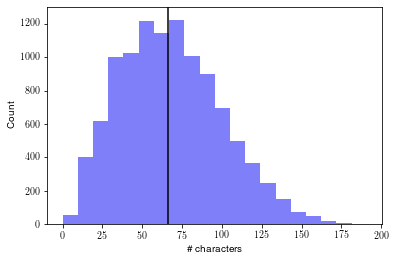

In [28]:
plt.hist(reviews_len, bins=20, color=(2/255, 0, 247/255, 0.5))
plt.vlines(np.median(reviews_len), 0, 1500)
# plt.vlines(np.quantile(reviews_len, q=0.75), 0, 1500, color='red')
plt.ylim([0, 1300])

plt.xlabel('\# characters')
plt.ylabel('Count')
# plt.savefig('cnn_character_matrix.pdf', bbox_inches='tight')
plt.show()

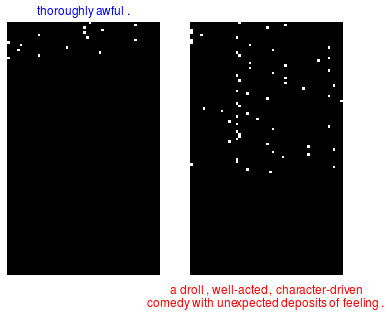

In [29]:
plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 1)
position = 180
title = plt.title(neg_review.review.iloc[position])
plt.setp(title, color='blue')
plt.imshow([p for p in process_review(neg_review.review.iloc[position], max_len=100)], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
t1 = pos_review.review.iloc[position]
t2 = 'a droll , well-acted , character-driven \ncomedy with unexpected deposits of feeling . '
title = plt.title(t2, y=-0.15)
plt.setp(title, color='red')
plt.imshow([p for p in process_review(pos_review.review.iloc[position], max_len=100)], cmap='gray')
plt.axis('off')


# plt.savefig('cnn_character_example.pdf', bbox_inches='tight')
# plt.show()

In [194]:
MAX_LEN_SEQ = 66 # 66 - median -- in characters

processed_review = all_reviews.review.apply(lambda review: process_review(review, max_len=MAX_LEN_SEQ))

X = processed_review.to_numpy().tolist()
y = all_reviews.sentiment.values

In [224]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
        """
        Create F1 metric for Keras
        From: https://stackoverflow.com/a/45305384/9511702
        """
        def recall(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = tp / (possible_positives + K.epsilon())
            return recall
        
        def precision(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = tp / (predicted_positives + K.epsilon())
            return precision
        
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

            
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(NUM_CHARS, MAX_LEN_SEQ, 1)),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    metrics = ['accuracy', tf.keras.metrics.AUC(), f1] 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model

In [225]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    
def train(X_train, y_train, X_test, y_test, epochs=30, batch_size=32):
    model = build_model()
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        #callbacks=[early_stopping],
                        verbose=0)
    test_results = model.evaluate(X_test, y_test, batch_size)
    return history.history, model, test_results 

In [226]:
from sklearn.model_selection import KFold

def X_transform(X):
    X = tf.convert_to_tensor(X)
    X = tf.reshape(X, [X.shape[0], X.shape[2], X.shape[1], 1]) # one channel (black or white)
    return X

def y_transform(y):
    return tf.convert_to_tensor(y)

def cross_validate(X, y, split_size=3):
    results = []
    models = []
    test_results = []
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X, y):
        X_train = X_transform(X[train_idx])
        y_train = y_transform(y[train_idx])
        X_test = X_transform(X[val_idx])
        y_test = y_transform(y[val_idx])
        result, model, test_result = train(X_train, y_train, X_test, y_test)
        results.append(result)
        models.append(model)
        test_results.append(test_result)
    return results, models, test_results

In [227]:
X_new = np.array(X)
y_new = np.array(y)

results, models, test_results = cross_validate(X_new, y_new)

3565/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [228]:
# plot results - loss, metrics combine all and draw approx line (e.g. smooth line line in ggplot

# test_results
test_results

[[3.8158375588907933, 0.44179523, 0.0, 0.6091598],
 [3.5971997551964843, 0.5102384, 0.51485664, 0.4541428],
 [16.851384706216308, 0.018232819, 0.0, 0.0]]

In [229]:
def predict(model, review, max_len=MAX_LEN_SEQ, shape=(MAX_LEN_SEQ, NUM_CHARS, 1)):
    input_ = [p for p in process_review(review, max_len=max_len)]
    input_ = tf.cast(input_, tf.float32)
    input_ = tf.reshape(input_, shape)
    input_ = input_[np.newaxis, ...]
    prediction = model.predict(input_)[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [230]:
shape = (NUM_CHARS, MAX_LEN_SEQ, 1)
predict(models[2], "I really like this film, one of the best I've ever seen", shape=shape)

0.9967031
Positive review with probability: 99.67%


In [231]:
predict(models[2], 'I like this film and recommend to everyone.', shape=shape)

0.9999833
Positive review with probability: 100.00%


In [232]:
predict(models[2], "The movie was terrible, not worth watching once again", shape=shape)

0.9999994
Positive review with probability: 100.00%


In [233]:
for i, model in enumerate(models):
    print(f"\nModel {i}: \n")
    predict(model, "I really like this film, one of the best I've ever seen", shape=shape)
    predict(model, 'I like this film and recommend to everyone.', shape=shape)
    predict(model, "The movie was terrible, not worth watching once again", shape=shape)


Model 0: 

0.01804958
Negative review with probability: 98.20%
0.026587222
Negative review with probability: 97.34%
0.40356475
Negative review with probability: 59.64%

Model 1: 

0.10280695
Negative review with probability: 89.72%
0.980261
Positive review with probability: 98.03%
0.6333445
Positive review with probability: 63.33%

Model 2: 

0.9967031
Positive review with probability: 99.67%
0.9999833
Positive review with probability: 100.00%
0.9999994
Positive review with probability: 100.00%


In [234]:
def plot_result(result):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.plot(result['loss'], label='train')
    plt.plot(result['val_loss'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    
    auc_metrics = []
    for key, value in result.items():
        if 'auc' in key:
            auc_metrics.append(key)
    plt.subplot(1, 4, 2)
    plt.plot(result[auc_metrics[0]], label='train')
    plt.plot(result[auc_metrics[1]], label='test')
    plt.xlabel('epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(result['f1'], label='train')
    plt.plot(result['val_f1'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('$$F_1$$')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(result['accuracy'], label='train')
    plt.plot(result['val_accuracy'], label='test')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

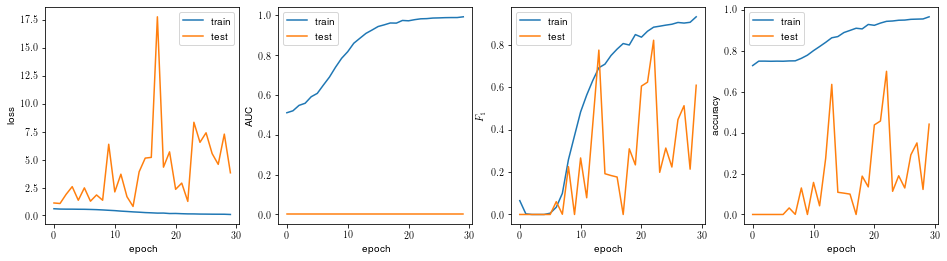

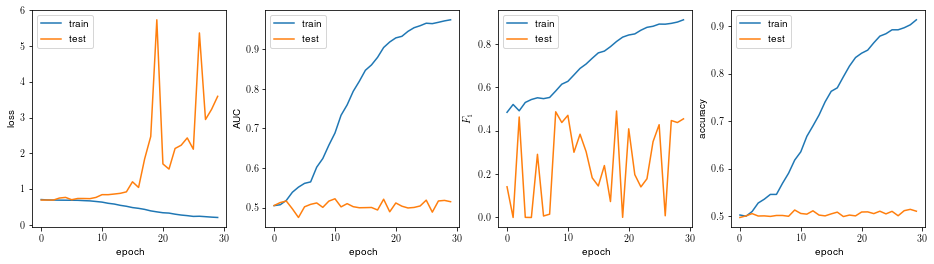

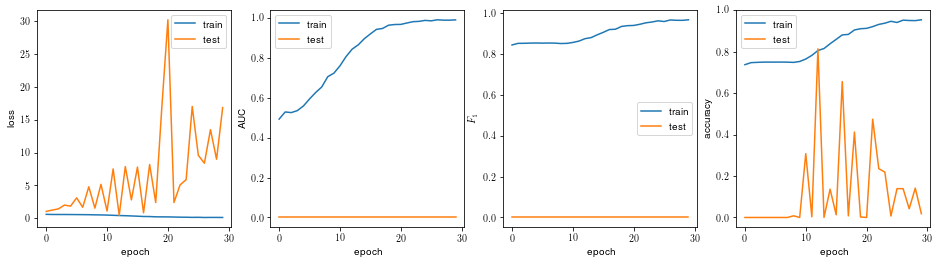

In [235]:
for r in results:
    plot_result(r)